In [1]:
import numpy as np
np.random.seed(1337) # for reproducibility
import tensorflow as tf
from keras import backend as K
from keras.layers.core import Lambda
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Input,Dense,GRU,LSTM,Concatenate,Dropout,Activation,Add, Masking
from keras.layers.pooling import AveragePooling1D,MaxPooling1D
from keras.layers.core import Flatten
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D
from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.core import Reshape
from keras.backend import shape
from keras.utils import plot_model
from keras.layers.merge import Multiply,Concatenate
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from keras.optimizers import RMSprop,Adadelta,Adam
from keras.callbacks import Callback
import sys

In [2]:
def calc_test_result(result, test_label, test_mask):
    true_label=[]
    predicted_label=[]

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            if test_mask[i][j]==1:
                true_label.append(np.argmax(test_label[i,j] ))
                predicted_label.append(np.argmax(result[i,j] ))
    
    print("Confusion Matrix :")
    print(confusion_matrix(true_label, predicted_label))
    print("Classification Report :")
    print(classification_report(true_label, predicted_label,digits=4))
    print("Accuracy ", accuracy_score(true_label, predicted_label))
    print("Macro Classification Report :")
    print(precision_recall_fscore_support(true_label, predicted_label,average='macro'))
    print("Weighted Classification Report :")
    print(precision_recall_fscore_support(true_label, predicted_label,average='weighted'))

In [3]:
NUM_LABELS=4
dim_proj=250

In [4]:
def Bimodal():
    with open('../input/multimodal-sentiment/unimodal.pickle', 'rb') as handle:
        unimodal_activations = pickle.load(handle, encoding = 'latin1')
        
    train_data_t = unimodal_activations['text_train']
    train_data_a = unimodal_activations['audio_train']
    train_label = unimodal_activations['train_label']
    test_data_t = unimodal_activations['text_test']
    test_data_a = unimodal_activations['audio_test']
    test_label = unimodal_activations['test_label']
    
    dim_1 = train_data_t.shape[0]
    max_len = train_data_t.shape[1]
    dim_text = train_data_t.shape[2]
    dim_aud = train_data_a.shape[2]
    
    dimt_1 = test_data_t.shape[0]
    maxt_len = test_data_t.shape[1]
    
    test_mask=unimodal_activations['test_mask']
    train_mask=unimodal_activations['train_mask']
    
    for i in range(dim_1):
        for j in range(max_len):
            if train_mask[i][j] == 0.0 :
                train_data_t[i,j,:]=0.0
                train_data_a[i,j,:]=0.0

    for i in range(dimt_1):
        for j in range(maxt_len):
            if test_mask[i][j] == 0.0 :
                test_data_t[i,j,:]=0.0
                test_data_a[i,j,:]=0.0
    
    x=Input(shape=(max_len,dim_text,), name='bi_t_input')
    y=Input(shape=(max_len,dim_aud,), name='bi_a_input')
    d1=Dense(dim_proj, activation='tanh', use_bias=False, trainable=True, name='bid1')(x)
    d2=Dense(dim_proj, activation='tanh', use_bias=False, trainable=True, name='bid2')(y)
    c1=Concatenate(axis=-1)([d1, d2])
    g1=GRU(350, return_sequences=True, dropout=0.2, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3))(c1)
    d3=TimeDistributed(Dense(NUM_LABELS,activation='softmax',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)))(g1)
    
    model=Model([x, y], outputs=d3)
    model.compile(loss='categorical_crossentropy',optimizer=Adam(0.0001),metrics=['accuracy'])
    print(model.summary())
    
    model.fit([train_data_t, train_data_a], train_label, epochs=10, batch_size=20, validation_split=0.1)
    
    final = model.predict([test_data_t, test_data_a])
    calc_test_result(final, test_label, test_mask)
    
    return final, test_label, test_mask
    

In [5]:
result, test_label, test_mask = Bimodal()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bi_t_input (InputLayer)         [(None, 110, 100)]   0                                            
__________________________________________________________________________________________________
bi_a_input (InputLayer)         [(None, 110, 100)]   0                                            
__________________________________________________________________________________________________
bid1 (Dense)                    (None, 110, 250)     25000       bi_t_input[0][0]                 
__________________________________________________________________________________________________
bid2 (Dense)                    (None, 110, 250)     25000       bi_a_input[0][0]                 
_______________________________________________________________________________________

In [6]:
y_true=[]
y_pred=[]

for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        if test_mask[i][j]==1:
                y_true.append(np.argmax(test_label[i,j] ))
                y_pred.append(np.argmax(result[i,j] ))

<Figure size 432x288 with 0 Axes>

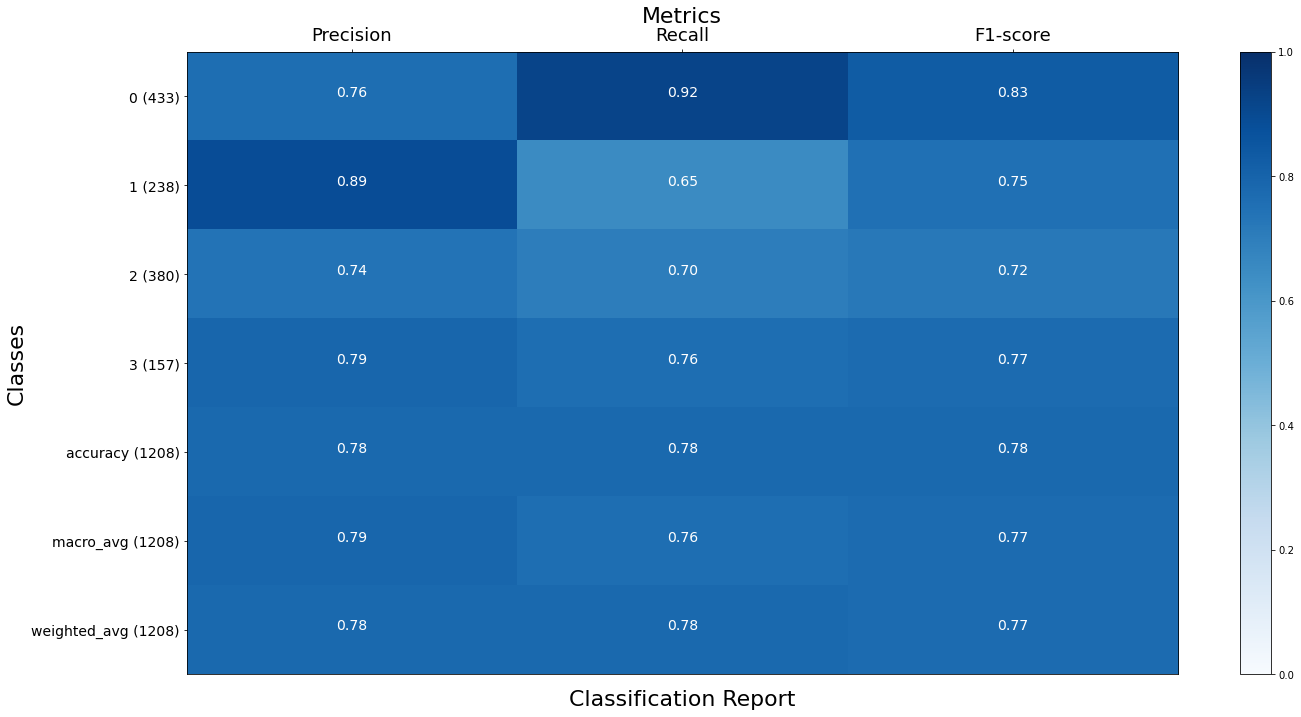

<Figure size 432x288 with 0 Axes>

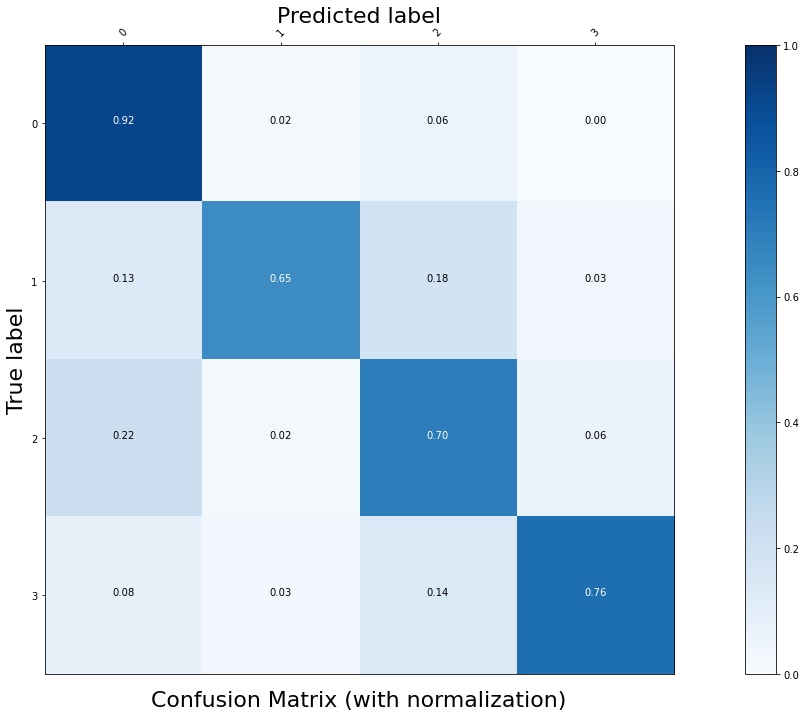

<Figure size 432x288 with 0 Axes>

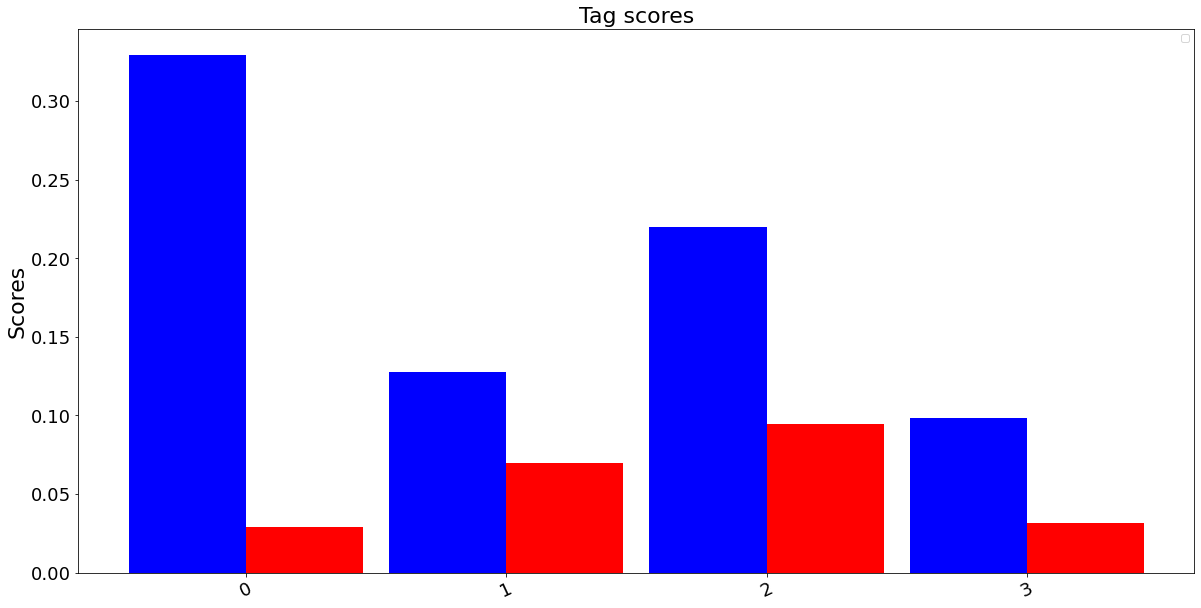

In [7]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

def get_report(y_true, y_pred, classes):
    clf_report = classification_report(y_true, y_pred, labels=classes, zero_division=0)
    clf_report = clf_report.replace('\n\n', '\n')
    clf_report = clf_report.replace('micro avg', 'micro_avg')
    clf_report = clf_report.replace('macro avg', 'macro_avg')
    clf_report = clf_report.replace('weighted avg', 'weighted_avg')
    clf_report = clf_report.replace(' / ', '/')
    lines = clf_report.split('\n')

    class_names, plotMat, support = [], [], []
    for line in lines[1:]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        v = [float(x) for x in t[1: len(t) - 1]]
        if len(v) == 1 : v = v * 3
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    plotMat = np.array(plotMat)
    support = np.array(support)
    return class_names, plotMat, support

def get_scores(y_true, y_pred, classes):
    correct, wrong = {}, {}
    for tag in classes:
        correct[tag] = 0
        wrong[tag] = 0
        
    for tag, pred in zip(y_true, y_pred):
        if tag == pred:
            correct[tag] += 1
        else:
            wrong[tag] += 1
            
    scores = []
    total = len(y_true)
    for tag in classes:
        cur = np.array([correct[tag], wrong[tag]])
        scores.append(cur / total)
    return np.array(scores)
    
def plot_confusion_matrix(classes, mat, normalize=True, cmap=plt.cm.Blues):
    cm = np.copy(mat)
    title = 'Confusion Matrix (without normalization)'
    if normalize:
        cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
        title = title.replace('without', 'with')
    plt.clf()    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    thresh = 1 / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if (cm[i, j] > thresh) else "black"
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color=color)
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches="tight", transparent=True)
    plt.show()
    
def plot_clf_report(classes, plotMat, support, cmap=plt.cm.Blues):
    title = 'Classification Report'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(classes[idx], sup) for idx, sup in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)
    thresh = np.max(plotMat) / 2
    thresh = 1 / 2
    for i in range(plotMat.shape[0]):
        for j in range(plotMat.shape[1]):
            color = "white" if (plotMat[i, j] > thresh) else "black"
            plt.text(j, i, format(plotMat[i, j], '.2f'), horizontalalignment="center", color=color, fontsize=14)

    plt.xlabel('Metrics',fontsize=22)
    plt.ylabel('Classes',fontsize=22)
    plt.tight_layout()
    plt.savefig('classification_report.png', bbox_inches="tight", transparent=True)
    plt.show()
    
def plot_tag_scores(classes, scores, normalize=True):
    plt.clf()
    width = 0.45
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_tick_params(labelsize=18, rotation=25)
    ax.yaxis.set_tick_params(labelsize=18)
    range_bar1 = np.arange(len(classes))
    rects1 = ax.bar(range_bar1, tuple(scores[:, 0]), width, color='b')
    rects2 = ax.bar(range_bar1 + width, tuple(scores[:, 1]), width, color='r')

    ax.set_ylabel('Scores',fontsize=22)
    ax.set_title('Tag scores', fontsize=22)
    ax.set_xticks(range_bar1 + width / 2)
    ax.set_xticklabels(classes)

    ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'), fontsize=20)
    plt.legend()
    plt.savefig('tag_scores.png', bbox_inches="tight", transparent=True)
    plt.show()


classes=[0,1,2, 3]
class_names, report, support = get_report(y_true, y_pred, classes)
cm = confusion_matrix(y_true, y_pred, labels=classes)
scores = get_scores(y_true, y_pred, classes)
plot_clf_report(class_names, report, support)
plot_confusion_matrix(classes, cm)
plot_tag_scores(classes, scores)